
[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Files already downloaded and verified
Files already downloaded and verified
Training Data:  tensor([[-1.2854, -1.5955, -1.4598,  ...,  0.5100, -0.5825, -0.8167],
        [ 0.5562,  0.0134, -0.3936,  ...,  0.4905,  0.5491,  0.5881],
        [ 2.5141,  2.4753,  2.4753,  ..., -0.6020, -0.6020, -0.5825],
        ...,
        [ 0.9633,  1.4479,  1.5836,  ...,  0.1979, -1.2654, -1.5971],
        [-1.8863, -1.2854, -1.1303,  ..., -1.5190, -1.3629, -1.4215],
        [-1.2272, -1.6537, -1.2466,  ...,  0.2564,  0.1979,  0.0418]])
Training Data Label:  tensor([6, 9, 9,  ..., 3, 7, 1])
Positive Data:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.5100, -0.5825, -0.8167],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4905,  0.5491,  0.5881],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.6020, -0.6020, -0.5825],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1979, -1.2654, -1.5971],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.5190, -1.3629, -1.4215],
        [ 0.0000,  1.0000,  0.0000,  ...

  0%|          | 0/1 [00:00<?, ?it/s]

Training Layer 0 ...


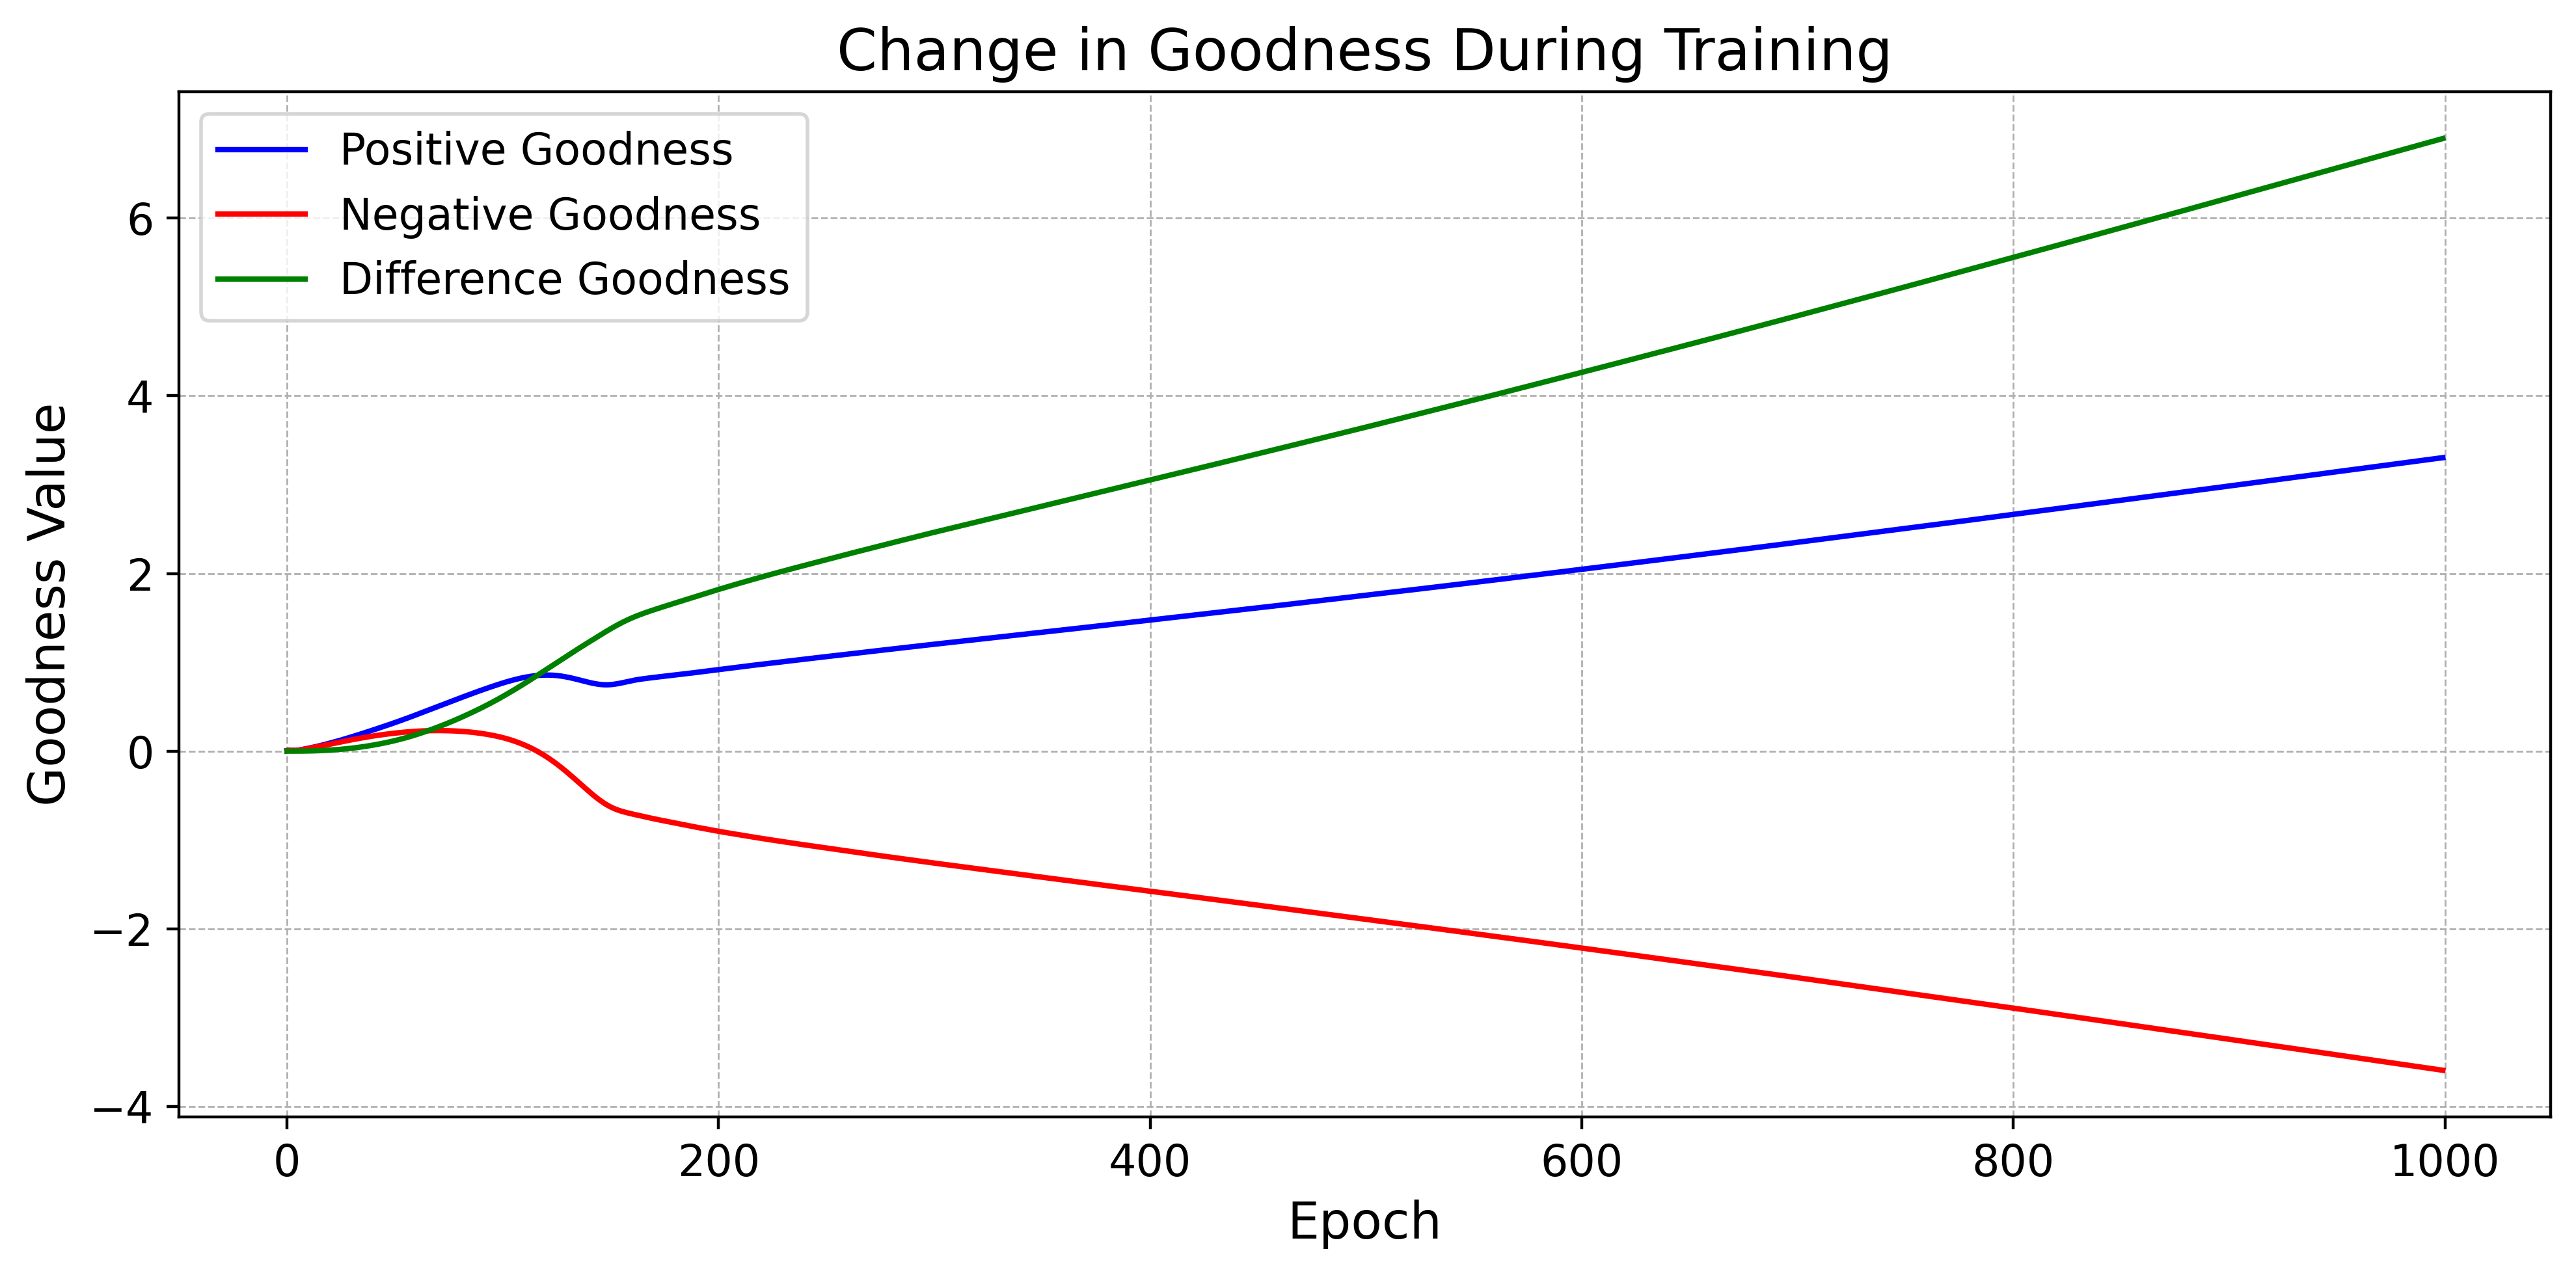

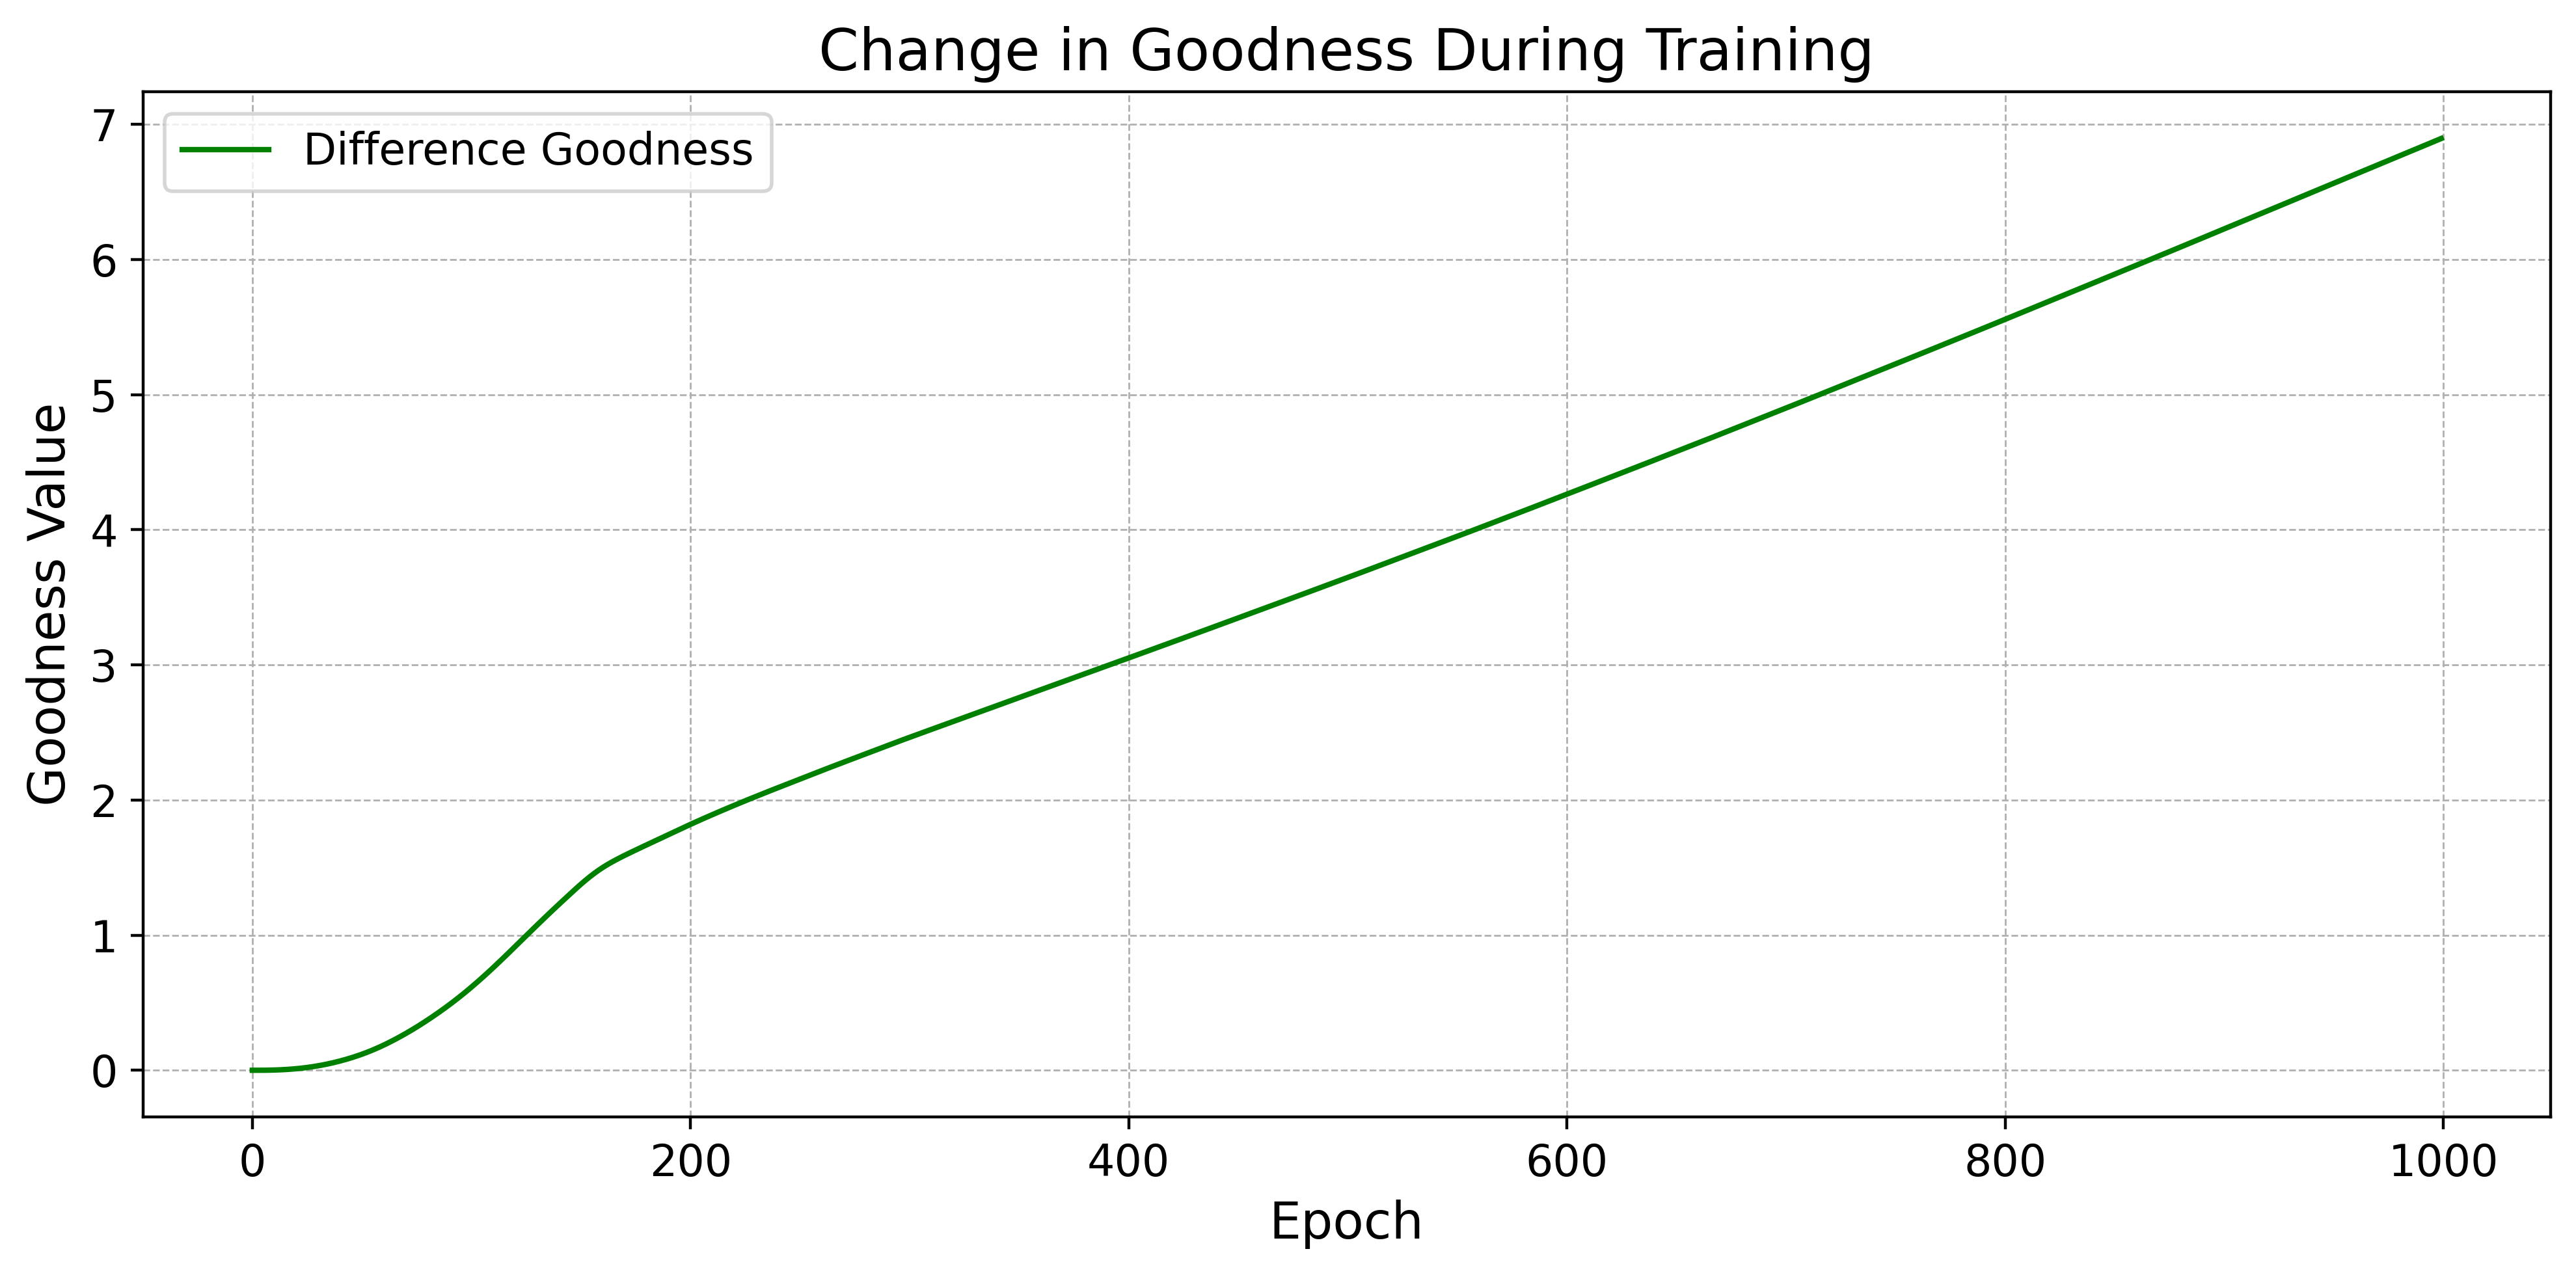

Training Layer 1 ...


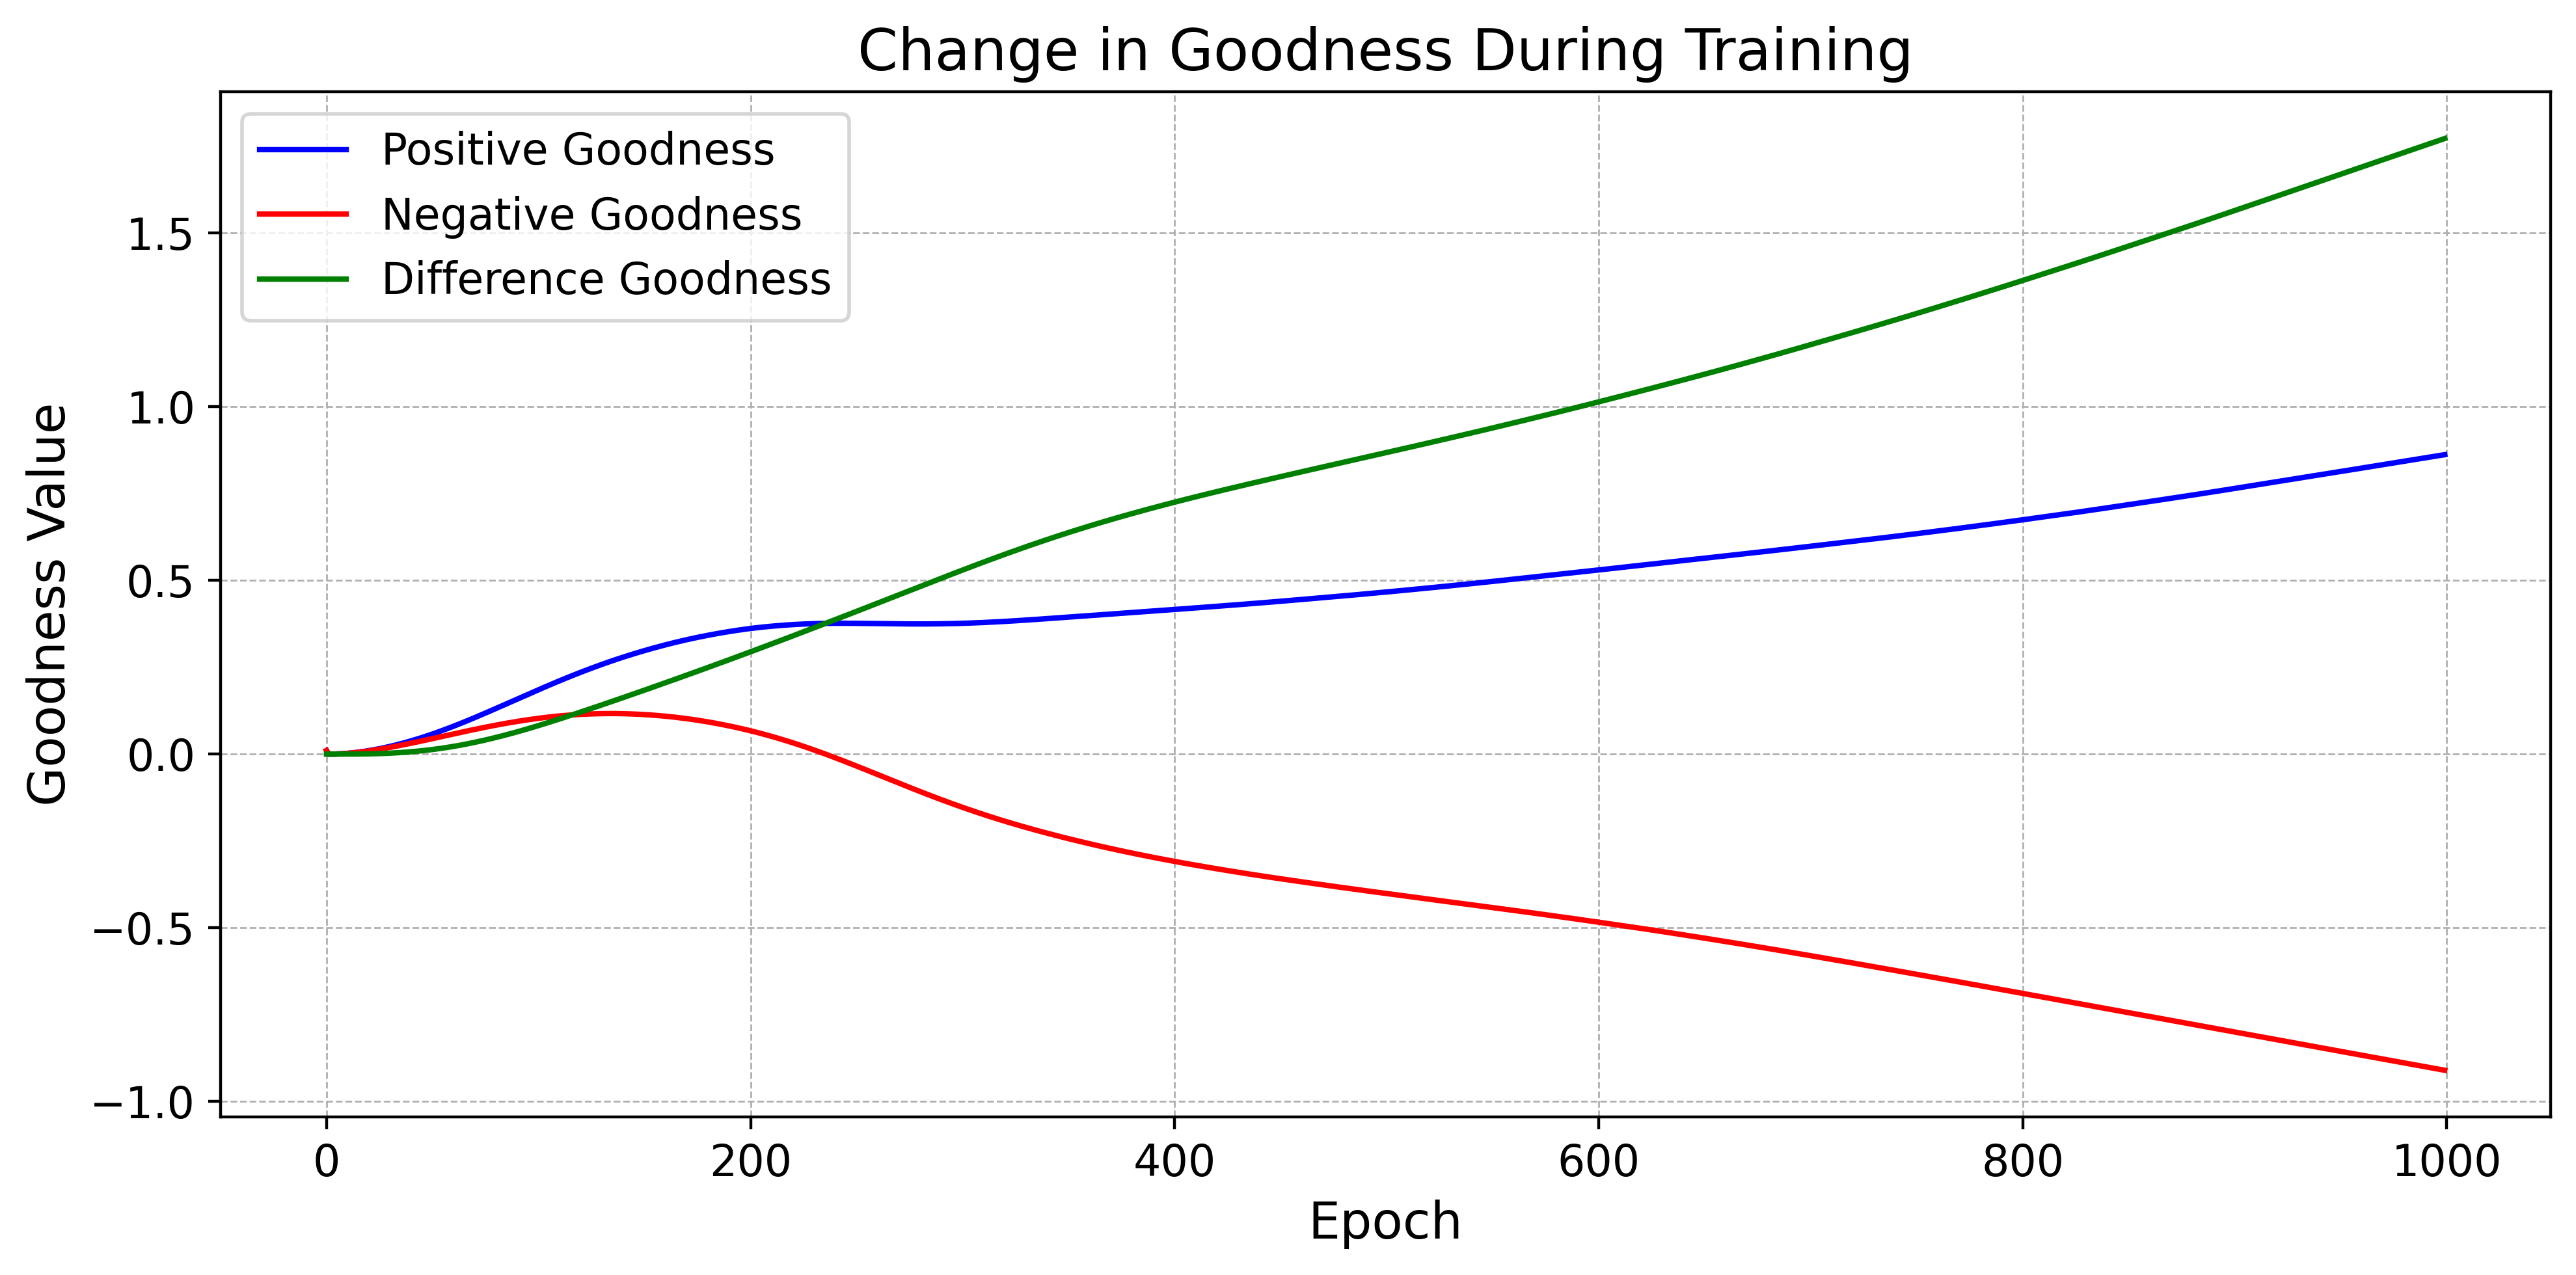

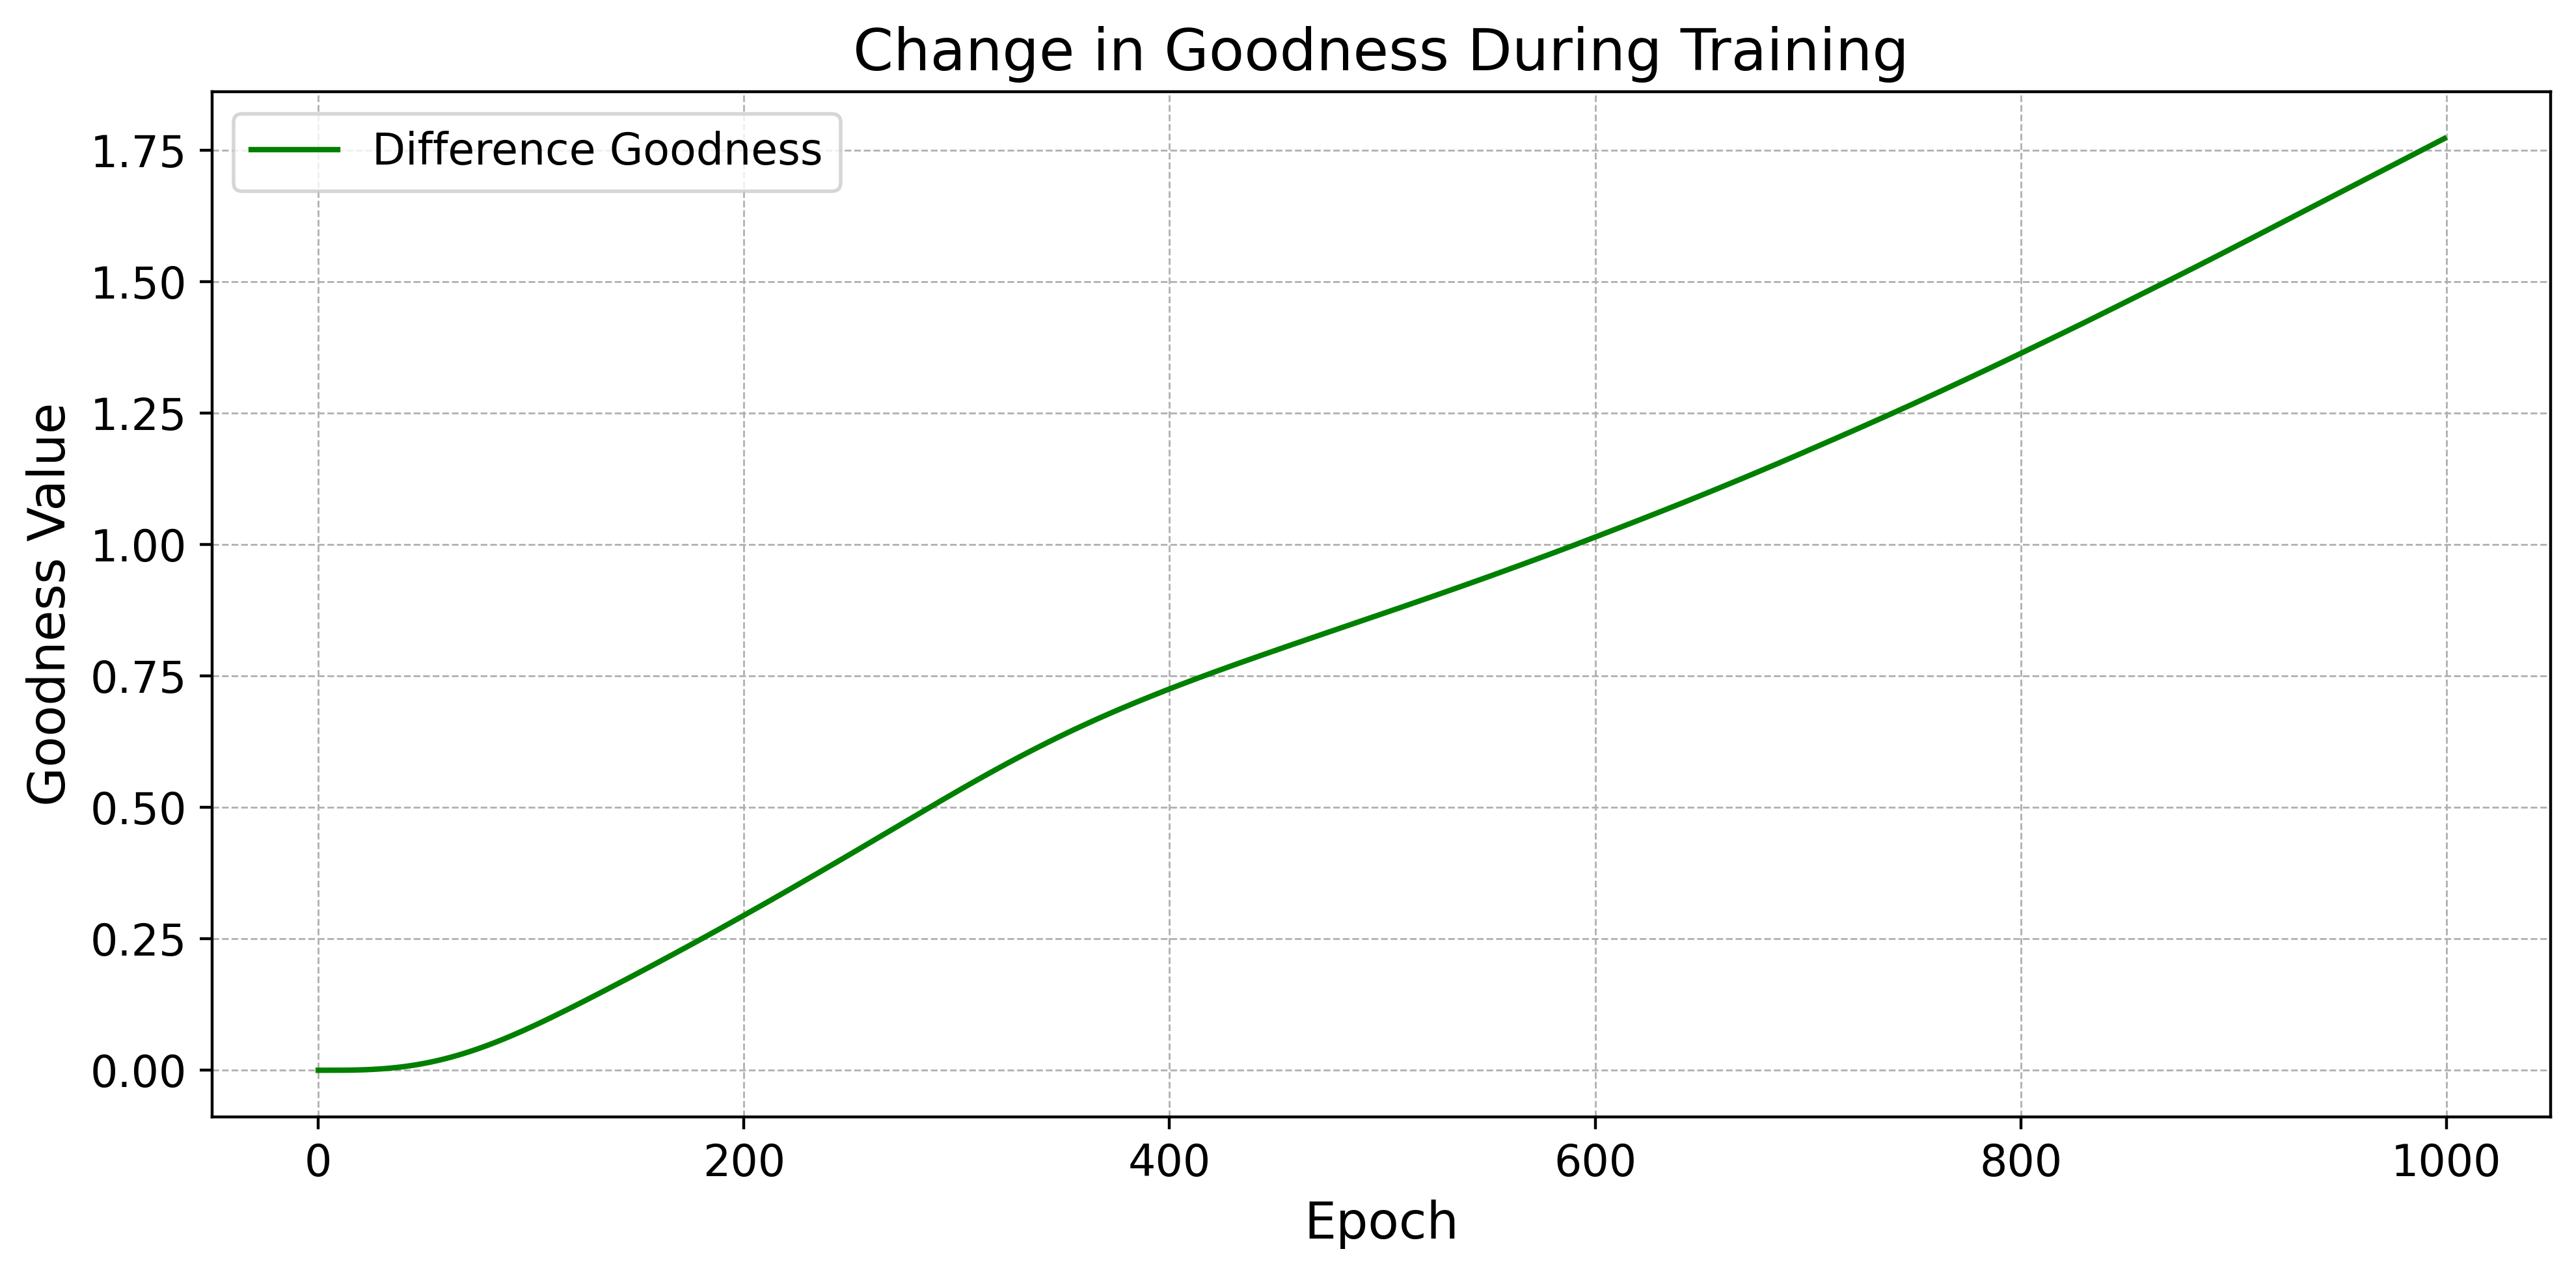

100%|██████████| 1/1 [01:39<00:00, 99.81s/it]


Training Accuracy:  0.6076666712760925
Testing Accuracy:  0.48783332109451294


In [2]:
!pip install tqdm
!pip install matplotlib

import random

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

import torch.nn as nn

from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam

number_of_epochs = 1000

hidden_layer_neurons = 1000

class Layer(nn.Linear):
    # hebbian_weights_layer_one_zeroth = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    # hebbian_weights_layer_two_zeroth = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    hebbian_weights_layer_one = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    # hebbian_weights_layer_one_quadra = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    hebbian_weights_layer_two = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    # hebbian_weights_layer_two_quadra = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    # hebbian_weights_layer_one_third = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    # hebbian_weights_layer_two_third = nn.Parameter(torch.ones(10, hidden_layer_neurons).cuda())
    # 
    def __init__(self, in_features, out_features, bias=True, device=None, d_type=None, is_hinge_loss=True):
        super().__init__(in_features, out_features, bias, device, d_type)
        self.activation = torch.nn.ReLU()
        self.learning_rate = 0.01
        self.optimizer = Adam(self.parameters(), lr=self.learning_rate)
        self.threshold = 0.0
        self.num_of_epochs = number_of_epochs
        self.is_hinge_loss = is_hinge_loss
        self.hebbian_optimizer = Adam([Layer.hebbian_weights_layer_two, Layer.hebbian_weights_layer_one], lr=0.01)
        
        
    def compute_hebbian_activity(self, labels, values, layer_num):
        
        
        if layer_num == 0:
            hebbian_value = torch.mm(values.pow(2) * self.layer_weights[layer_num], self.hebbian_weights_layer_one.T) * labels
        else:
            hebbian_value = torch.mm(values, self.hebbian_weights_layer_two.T) * labels
        return hebbian_value.mean(1).cuda()
    
    
    def forward(self, input: Tensor) -> Tensor:
        normalized_input = input / (input.norm(2, 1, keepdim=True) + 1e-4)
        output = torch.mm(normalized_input, self.weight.T) + self.bias.unsqueeze(0)
        return self.activation(output)

    def balanced_loss(self, positive_goodness, negative_goodness, alpha=4.0):
        delta = positive_goodness - negative_goodness
        per_instance_loss = torch.log(1 + torch.exp(-alpha * delta))
        return per_instance_loss.mean()  


    def soft_plus_loss(self, positive_goodness, negative_goodness, is_second_phase=False):
        if is_second_phase:
            threshold = self.threshold * 2
        else:
            threshold = self.threshold
        return torch.log(1 + torch.exp(torch.cat([
            -positive_goodness + threshold,
            negative_goodness - threshold]))).mean()


    def plot_goodness(self, positive_goodness, negative_goodness, difference):
        plt.figure(figsize=(10, 5), dpi=400)  # Higher dpi for better resolution
        plt.plot(positive_goodness, label='Positive Goodness', color='b')
        plt.plot(negative_goodness, label='Negative Goodness', color='r')
        plt.plot(difference, label='Difference Goodness', color='g')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Goodness Value', fontsize=14)
        plt.title('Change in Goodness During Training', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tick_params(labelsize=12)
        plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
        plt.savefig('Goodness_Tracking.pdf', format='pdf')  # Save as PDF
        plt.show()

    def plot_difference(self, difference):
        plt.figure(figsize=(10, 5), dpi=400)
        plt.plot(difference, label='Difference Goodness', color='g')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Goodness Value', fontsize=14)
        plt.title('Change in Goodness During Training', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig('Difference_Goodness.pdf', format='pdf')
        plt.show()
        
        
    def train_layer(self, positive_input, negative_input, layer_num):
        positive_goodness_history = []
        negative_goodness_history = []
        difference_history = []
        
        for _ in range(number_of_epochs):
            positive_output = self.forward(positive_input)  # Shape: [batch_size, 500]
            negative_output = self.forward(negative_input)
            
            # First Layer
            if layer_num == 0:
                # positive_goodness = (torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_one_zeroth) * positive_output + torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_one) * positive_output.pow(2) + torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_one_quadra) * positive_output.pow(4) + torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_one_third) * positive_output.pow(3)).mean(1)
                positive_goodness = (torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_one) * positive_output).mean(1)
                # negative_goodness = (torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_one_zeroth) * negative_output + torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_one) * negative_output.pow(2) + torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_one_quadra) * negative_output.pow(4) + torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_one_third) * negative_output.pow(3)).mean(1)
                negative_goodness = (torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_one) * negative_output).mean(1)
            else:
                # Second Layer
                # positive_goodness = (torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_two_zeroth) * positive_output + torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_two) * positive_output.pow(2) + torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_two_quadra) * positive_output.pow(4) + torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_two_third) * positive_output.pow(3)).mean(1)
                positive_goodness = (torch.mm(Network.positive_labels, Layer.hebbian_weights_layer_two) * positive_output).mean(1)
                # negative_goodness = (torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_two_zeroth) * positive_output + torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_two) * negative_output.pow(2) + torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_two_quadra) * negative_output.pow(4) + torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_two_third) * negative_output.pow(3)).mean(1)
                negative_goodness = (torch.mm(Network.negative_labels, Layer.hebbian_weights_layer_two) * negative_output).mean(1)
            
            positive_goodness_history.append(positive_goodness.mean().item())
            negative_goodness_history.append(negative_goodness.mean().item())
            difference_history.append(positive_goodness.mean().item() - negative_goodness.mean().item())

            if self.is_hinge_loss:
                loss = self.soft_plus_loss(positive_goodness, negative_goodness)
            else:
                loss = self.balanced_loss(positive_goodness, negative_goodness)

            self.optimizer.zero_grad()
            self.hebbian_optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.hebbian_optimizer.step()
        
        self.plot_goodness(positive_goodness_history, negative_goodness_history, difference_history)
        self.plot_difference(difference_history)
        return self.forward(positive_input).detach(), self.forward(negative_input).detach()


class Network(nn.Module):
    # hebbian_weights = nn.Parameter(torch.ones(10, 774).cuda())
    positive_labels = []
    negative_labels= []
    def __init__(self, dimension_configs):
        super().__init__()
        self.layers = []
        for i in range(len(dimension_configs) - 1):
            self.layers += [Layer(dimension_configs[i], dimension_configs[i + 1]).cuda()]
            
    def balanced_loss(self, positive_goodness, negative_goodness, alpha=4.0):
        delta = positive_goodness - negative_goodness
        per_instance_loss = torch.log(1 + torch.exp(-alpha * delta))
        return per_instance_loss.mean()  

    def mark_data(self, data, label):
        marked_data = data.clone().cuda()
        marked_data[:, :10] = 0
        marked_data[torch.arange(marked_data.size(0)), label] = 1
        return marked_data
    
    
    def predict(self, input_data):
        goodness_per_label = []
        for label in range(10):
            marked_data = self.mark_data(input_data, label)
            # hebbian_weight_one_zeroth = Layer.hebbian_weights_layer_one_zeroth[label, :]
            # hebbian_weight_two_zeroth = Layer.hebbian_weights_layer_two_zeroth[label, :]
            hebbian_weight_one = Layer.hebbian_weights_layer_one[label, :]
            hebbian_weight_two = Layer.hebbian_weights_layer_two[label, :]
            # hebbian_weight_one_third = Layer.hebbian_weights_layer_one_third[label, :]
            # hebbian_weight_two_third = Layer.hebbian_weights_layer_two_third[label, :]
            # hebbian_weight_one_quadra = Layer.hebbian_weights_layer_one_quadra[label, :]
            # hebbian_weight_two_quadra = Layer.hebbian_weights_layer_two_quadra[label, :]
            goodness = []
            for layer_num, layer in enumerate(self.layers):
                marked_data = layer(marked_data)
                if layer_num == 0:
                    goodness_value = (marked_data * hebbian_weight_one).mean(1)
                else:
                    goodness_value = (marked_data * hebbian_weight_two).mean(1)
                goodness.append(goodness_value)

            goodness_per_label.append(torch.sum(torch.stack(goodness), dim=0).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(dim=1)
    
    def compute_hebbian_activity(self, values):
        labels = values[:, :10].cuda()
        hebbian = values[:, 10:].cuda()
        hebbian_value = torch.mm(hebbian, self.hebbian_weights.T) * labels
        return hebbian_value.mean(1).cuda()
    
    
    def train_network(self, positive_goodness, negative_goodness, training_data, training_data_label):
        
        # positive_mean_values = []
        # negative_mean_values = []
        # 
        # for _ in tqdm(range(number_of_epochs)):
        #     positive_labels = positive_goodness[:, :10].cuda()
        #     positive_hebbian = positive_goodness[:, 10:].cuda()
        #     positive_hebbian_value = torch.mm(positive_hebbian, self.hebbian_weights.T.pow(2)) * positive_labels
        #     positive_mean_value = positive_hebbian_value.mean(1).cuda()
        #     positive_mean_values.append(positive_mean_value.mean().item())  # Store average for plotting
        # 
        #     negative_labels = negative_goodness[:, :10].cuda()
        #     negative_hebbian = negative_goodness[:, 10:].cuda()
        #     negative_hebbian_value = torch.mm(negative_hebbian, self.hebbian_weights.T.pow(2)) * negative_labels
        #     negative_mean_value = negative_hebbian_value.mean(1).cuda()
        #     negative_mean_values.append(negative_mean_value.mean().item())  # Store average for plotting
        # 
        #     loss = self.balanced_loss(positive_mean_value, negative_mean_value)
        #     self.hebbian_optimizer.zero_grad()
        #     loss.backward()
        #     self.hebbian_optimizer.step()
        # 
        # plt.figure(figsize=(10, 5))
        # plt.plot(positive_mean_values, label='Positive Mean Value', color='blue')
        # plt.plot(negative_mean_values, label='Negative Mean Value', color='red')
        # plt.title('Change in Mean Values Over Epochs')
        # plt.xlabel('Epochs')
        # plt.ylabel('Mean Value')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        # 
        for epoch in tqdm(range(1)):
            goodness_pos, goodness_neg = positive_goodness, negative_goodness
            negative_goodness = create_negative_data(training_data, training_data_label)
            goodness_neg = negative_goodness
            positive_labels = goodness_pos[:, :10]
            negative_labels = negative_goodness[:, :10]

            Network.positive_labels = nn.Parameter(positive_labels.cuda())
            Network.negative_labels = nn.Parameter(negative_labels.cuda())
            for i, layer in enumerate(self.layers):
                print('Training Layer', i, '...')
                goodness_pos, goodness_neg = layer.train_layer(goodness_pos, goodness_neg, i)
            
        


def load_CIFAR10_data(train_batch_size=30000, test_batch_size=6000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        CIFAR10('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        CIFAR10('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_FashionMNIST_data(train_batch_size=60000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.2860,), (0.3530,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        FashionMNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        FashionMNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_MNIST_data(train_batch_size=50000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader


def create_positive_data(data, label):
    positive_data = data.clone()
    positive_data[:, :10] = 0.0

    for i in range(positive_data.shape[0]):
        positive_data[i][label[i]] = 1.0

    return positive_data


def create_negative_data(data, label, seed=None):
    if seed is not None:
        random.seed(seed)

    negative_data = data.clone()
    negative_data[:, :10] = 0.0

    for i in range(negative_data.shape[0]):
        possible_answers = list(range(10))
        possible_answers.remove(label[i])
        false_label = random.choice(possible_answers)
        negative_data[i][false_label] = 1.0

    return negative_data



def prepare_data():
    torch.manual_seed(4321)
    training_data_loader, testing_data_loader = load_CIFAR10_data()

    training_data, training_data_label = next(iter(training_data_loader))

    testing_data, testing_data_label = next(iter(testing_data_loader))
    testing_data, testing_data_label = testing_data.cuda(), testing_data_label.cuda()

    print(f"Training Data: ", training_data)
    print(f"Training Data Label: ", training_data_label)

    training_data, training_data_label = training_data.cuda(), training_data_label.cuda()

    positive_data = create_positive_data(training_data, training_data_label)
    print(f"Positive Data: ", positive_data)

    negative_data = create_negative_data(training_data, training_data_label)
    print(f"Negative Data: ", negative_data)

    return positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label


if __name__ == "__main__":
    torch.cuda.empty_cache()
    torch.manual_seed(1234)
    positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label = prepare_data()
    network = Network([3072, hidden_layer_neurons, hidden_layer_neurons]).cuda() #3072
    network.train_network(positive_data, negative_data, training_data, training_data_label)
    print("Training Accuracy: ", network.predict(training_data).eq(training_data_label).float().mean().item())
    print("Testing Accuracy: ", network.predict(testing_data).eq(testing_data_label).float().mean().item())